In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from soynlp.normalizer import repeat_normalize
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, Trainer, TrainingArguments,EarlyStoppingCallback
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import re
import numpy as np


/root/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-18 02:30:56.335511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 02:30:57.604978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [56]:
df=pd.read_csv("../data/labeled.csv", encoding="utf-8")

### **데이터 확인**

In [57]:
df

,문장,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,1
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1
...,...,...
79766,기사가 더 자극적이고 지랄이다 기레기야,1
79767,나는 글쓴게이 말도 맞다고 본다,1
79768,항상 여자로 ㅡ ㅡ 저지랄 들이야 남자들 벗겨봐라,1
79769,첫번째 이유가 ㄹㅇ 맞지특히나 뉴스나 기사 몇줄읽은 학생들끼리 대화해도 서로 존나 ...,1


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79771 entries, 0 to 79770
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   문장      79771 non-null  object
 1   label   79771 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


### **라벨링**

In [59]:
import pandas as pd
import json

# 제이슨 파일로부터 욕설 사전 불러오기
with open('../dict/swear_list.json', 'r') as f:
    swear_dict = json.load(f)
    swear_words = swear_dict['욕설']

# 욕설이 포함되어 있는지 검사하여 label 컬럼 추가
def check_swear(text):
    for swear in swear_words:
        if swear in text:
            return 1
    return 0

df['label'] = df['문장'].apply(check_swear)

In [60]:
df

,문장,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,0
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1
...,...,...
79766,기사가 더 자극적이고 지랄이다 기레기야,1
79767,나는 글쓴게이 말도 맞다고 본다,1
79768,항상 여자로 ㅡ ㅡ 저지랄 들이야 남자들 벗겨봐라,1
79769,첫번째 이유가 ㄹㅇ 맞지특히나 뉴스나 기사 몇줄읽은 학생들끼리 대화해도 서로 존나 ...,1


### **데이터 불균형 확인**

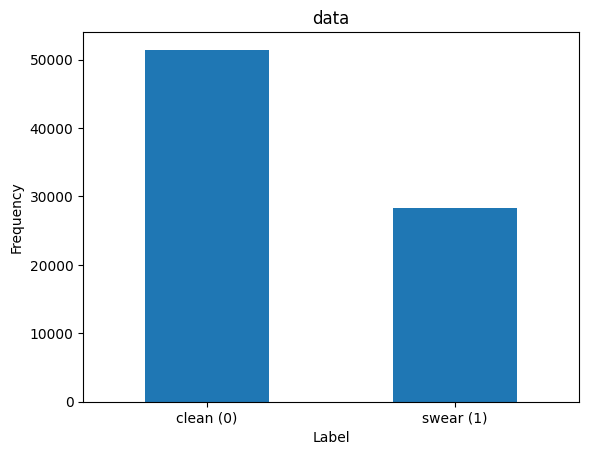

In [61]:
import matplotlib.pyplot as plt

# label 값에 따른 갯수 세기
label_counts = df['label'].value_counts()

# 시각화
label_counts.plot(kind='bar')
plt.title('data')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['clean (0)', 'swear (1)'], rotation=0)
plt.show()


In [62]:
df["label"].value_counts()

label
0    51437
1    28334
Name: count, dtype: int64

In [63]:
import pandas as pd

# 크롤링 데이터 : 욕설데이터에서 랜덤으로 추출
file_path = '../data/label_1_data.csv'
cdf = pd.read_csv(file_path)
df_sampled = cdf.sample(n=71666, random_state=65)
df_sampled



,문장,label
47721,글 다시 읽고와라 정박아새끼야,1
69084,무슨 애가 심기를 거스르는 언행 못하게 되어있거나 감성팔이나 그딴소리만 하고 있냐 ...,1
18658,누가 씨발 노산 하라고 협박했나ㅋㅋㅋㅋ 니들이 20대 때 이 남자 저 남자 즐기다가...,1
89178,그전 세대는 성깔이 있고 기만 셌는데. 지금은 몰염치에 정신병에 기세고 성깔있고 잘...,1
10239,걸려온 싸움은 피하지 않았다가 아니라 자기가 애들 괴롭히고 다니다가 찐따가 화내면 ...,1
...,...,...
5348,비참한 좆센징 역사 팩트에 개강간 쳐당하고 지랄발작 쳐할거면 니새끼 애미 위안부원정...,1
50895,디시 씹중독이었을 때는 이런 글들 ㅈㄴ 거부감 들었고 어떻게든 부정하고 반박하려고 ...,1
81068,"핵융합은 원자력보다 고준위폐기물이 좀 덜 나오고 대형사고 위험이 거의 없다, 라는게...",1
19263,청년 혜택? 난 청년인데 진심으로 받아 본적 없음.여성 혜택 이겟지. ㅡㅡ,1


In [64]:
file_path2 = '../data/label_0_data.csv'
ccdf = pd.read_csv(file_path2)
df_sampled0 = ccdf.sample(n=48563, random_state=65)
df_sampled0

,문장,label
2073,임신ㅇ안더ㅣ네 - dc App,0
146883,여기서 끝이 아니다! 여기서 끝이 아니다! 여기서 끝이 아니다! 여기서 끝이 아니다...,0
4395,남편이 보살인데?,0
45280,졸보새긔. 백쵸크 몰라? 그걸 몰라?,0
2190,정작 골격은 또 남자같네,0
...,...,...
64595,아줌유,0
105591,김상호인줄ㅋㅋ,0
48814,공산주의자임?,0
15174,이거 만화이름 뭐임,0


In [65]:
# df 결합
df = pd.concat([df, df_sampled, df_sampled0])

In [66]:
df

,문장,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,0
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1
...,...,...
64595,아줌유,0
105591,김상호인줄ㅋㅋ,0
48814,공산주의자임?,0
15174,이거 만화이름 뭐임,0


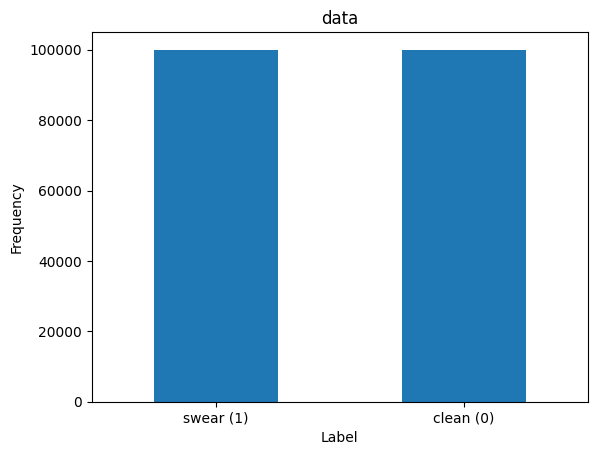

In [67]:
import matplotlib.pyplot as plt

# label 값에 따른 갯수 세기
label_counts = df['label'].value_counts()

# 시각화
label_counts.plot(kind='bar')
plt.title('data')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[1, 0], labels=['clean (0)', 'swear (1)'], rotation=0)
plt.show()

In [68]:
df

,문장,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,0
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1
...,...,...
64595,아줌유,0
105591,김상호인줄ㅋㅋ,0
48814,공산주의자임?,0
15174,이거 만화이름 뭐임,0


### **특수문자, url 이모지 제거**

In [2]:
df = pd.read_csv("balance_1.csv", encoding = "utf-8")

In [3]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
import numpy as np
import re
from sklearn.metrics import accuracy_score
import emoji

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣>]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def clean(x):
    x = pattern.sub(' ', x)
    x = emoji.replace_emoji(x, replace='') #emoji 삭제
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

Device: cuda


In [4]:
df['문장'] = df['문장'].apply(clean)

In [5]:
import re

def remove_repeated(word):
    # 중복된 문자 패턴을 간소화
    cleaned_text = re.sub(r'(ㅋ+|ㅎ+|ㅜ+|ㅠ+|ㅇㅇ+|ㅡ+|ㅉ+|~+|\b(?!18|28)\d+\b)', '', word)
    return cleaned_text

df['content'] = df['문장'].apply(remove_repeated)
df

,문장,label,content
0,좌배 까는건 ㅇㅂ,1.0,좌배 까는건 ㅇㅂ
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,1.0,집에 롱 패딩만 세 개다. 10년 더 입어야지
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1.0,개소리야 니가 빨갱이를 옹호하고 드루킹을 짓이라고 말못해서 삐진거야 빨갱아
3,세탁이라고 봐도 된다,0.0,세탁이라고 봐도 된다
4,애새끼가 초딩도 아니고 ㅋㅋ,1.0,애새끼가 초딩도 아니고
...,...,...,...
200006,타이타닉론 ㅋㅋ,0.0,타이타닉론
200007,한국 출산율 더 떨어지는 소리가 들린다 과연 그 끝은 어딜까요>? 맞춰보세요 여러분~~,0.0,한국 출산율 더 떨어지는 소리가 들린다 과연 그 끝은 어딜까요>? 맞춰보세요 여러분
200008,가챠겜이 언제부턴가 S R SR 애들이 밑바닥이더라? 알파벳장난질이긴 한데 꼴받음 ...,0.0,가챠겜이 언제부턴가 S R SR 애들이 밑바닥이더라? 알파벳장난질이긴 한데 꼴받음 ...
200009,사진없으면 노잼임 - dc App,0.0,사진없으면 노잼임 - dc App


In [6]:
import pandas as pd
import json
from konlpy.tag import Okt

# JSON 파일에서 욕설 사전 불러오기
with open('../dict/swear_list.json', 'r', encoding='utf-8') as file:
    profanity_dict = json.load(file)["욕설"]

# KoNLPy의 Okt 형태소 분석기 인스턴스화
okt = Okt()

# 문장을 토큰화하고 태깅하는 함수
def tag_profanity_ko(sentence):
    tokens = okt.morphs(sentence)
    tags = [ 'B' if token in profanity_dict else 'O' for token in tokens]
    return list(zip(tokens, tags))

# 데이터프레임의 각 문장에 대해 욕설 태깅 수행
df['content'] = df['content'].apply(tag_profanity_ko)

df


,문장,label,content
0,좌배 까는건 ㅇㅂ,1.0,"[(좌배, B), (까는건, O), (ㅇㅂ, O)]"
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,1.0,"[(집, O), (에, O), (롱, O), (패딩, O), (만, O), (세, ..."
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1.0,"[(개, O), (소리, O), (야, O), (니, O), (가, O), (빨갱이..."
3,세탁이라고 봐도 된다,0.0,"[(세탁, O), (이라고, O), (봐도, O), (된다, O)]"
4,애새끼가 초딩도 아니고 ㅋㅋ,1.0,"[(애, O), (새끼, B), (가, O), (초딩, O), (도, O), (아니..."
...,...,...,...
200006,타이타닉론 ㅋㅋ,0.0,"[(타이타닉, O), (론, O)]"
200007,한국 출산율 더 떨어지는 소리가 들린다 과연 그 끝은 어딜까요>? 맞춰보세요 여러분~~,0.0,"[(한국, O), (출산율, O), (더, O), (떨어지는, O), (소리, O)..."
200008,가챠겜이 언제부턴가 S R SR 애들이 밑바닥이더라? 알파벳장난질이긴 한데 꼴받음 ...,0.0,"[(가챠겜, O), (이, O), (언제, O), (부턴, O), (가, O), (..."
200009,사진없으면 노잼임 - dc App,0.0,"[(사진, O), (없으면, O), (노잼, O), (임, O), (-, O), (..."


### **토큰화**

In [7]:
# 'content' 칼럼만 유지하고, 나머지 칼럼은 모두 제거
df = df[['content']]
df

,content
0,"[(좌배, B), (까는건, O), (ㅇㅂ, O)]"
1,"[(집, O), (에, O), (롱, O), (패딩, O), (만, O), (세, ..."
2,"[(개, O), (소리, O), (야, O), (니, O), (가, O), (빨갱이..."
3,"[(세탁, O), (이라고, O), (봐도, O), (된다, O)]"
4,"[(애, O), (새끼, B), (가, O), (초딩, O), (도, O), (아니..."
...,...
200006,"[(타이타닉, O), (론, O)]"
200007,"[(한국, O), (출산율, O), (더, O), (떨어지는, O), (소리, O)..."
200008,"[(가챠겜, O), (이, O), (언제, O), (부턴, O), (가, O), (..."
200009,"[(사진, O), (없으면, O), (노잼, O), (임, O), (-, O), (..."


In [22]:
df.to_csv("tag.csv", index = False, encoding="utf-8")

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터 형태 변환 및 라벨 추출
sentences = []
labels = []

max_length = 128  # 설정하고자 하는 최대 길이

for _, row in df.iterrows():
    sentence = []
    label = []
    for word, tag in row['content'][:max_length]:  # 'content' 열에 저장된 데이터를 사용하되, max_length까지만 사용
        sentence.append(word)
        if tag == 'B':
            label.append(1)  # 욕설
        else:
            label.append(0)  # 욕설 아님
    sentences.append(" ".join(sentence))
    labels.append(label)

# 트레인/테스트 데이터 나누기
train_texts, val_texts, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2)


In [9]:
train_texts, train_labels

(['좌파 도 아니고 우파 도 아니면 뭔가 요 ?',
  '상남자 네',
  '알바니아 같은 후진국 이 저런 범죄자 하나 를 27년 이나 끈질기게 조사 했을 리 는 없고 미국 이나 캐나다 에서 행정 상 뭔가 뽀록 이 났을거 임 담당자 가 뭐 처리 하다가 어 ? 얘 여권 이상한데 ? 라든가 무언가 계기 가 있었을거고 파다 보니 진짜 신원 을 들킨거지',
  '작성자 개 병신 찢 갈이 수준',
  '와 짱깨 들 상상 이상 으로 많네',
  '기승 전 스섹 으로 끝나는 것 도 아니고 배우신 분 이 왜 저러지 ? 전문가 가 아닌 사람 이 봐도 말 도 안되는구만',
  '민주당 은 원래 저렇잖어',
  '몇 만의 탈레반 이 4000만 아프카니스탄 을 굴복 시 켯 다 . 지금 대한민국 을 보면 남 의 일 같지안습니다',
  '이런 놈 은 영구 히 구속 시켜라 온라인 디지털 성범죄 는 평생 감옥 행 이 해답 이다',
  ': 제발 페미니스트 라는 거 당당히 밝혀주세요 그 래야 피해 다닐수 있죠',
  '저건 ㅅㅂ 뭔 데 랍스타 보다 맛 잇냐',
  '걍 대가리 에 든게 없으니 입안 으로 다 밀어 넣고 본 거지 일본 은 쌀 비축 해놓은걸 로 대기근 도 넘기고 근대화 도 했다',
  '아닌 유동',
  '좆 센 징 똥 은 지나가다 걍 거 를 듯',
  '구청 장이 허가 해서 증축 했다잖아요',
  '???? 뭔 소리 를 하는거냐 ?',
  '업무 용 차로 드라이브 를 어떻게 가냐니 저 회사 압수수색 해라',
  '그 웬 ㅇㅈㄹ',
  '거지 자 집 들 은 구걸 을 하면서도 자좆심 을 못 버리노 고작 새끼손가락 크기 달렸으면서 말 이노',
  '그래도 국가 가 기업 로비 이겨내고 서민 편 든 건 자본주의 세상 에서 큰일 이긴 하다 어떻게 보면 아직 까지 게임 은 패 야 지지 를 얻는다 이 지랄 에서 못 벗어난것 같긴한데 어쨌건 결과 는 좋네',
  '그 놈 의 이슬람 율법 율법 에는 사람 은 죽어도 된다고 나오든 ?? 광신도 사이비 종교 의 한계 지',
  '근데 이건 남자 팬

In [10]:
from transformers import ElectraTokenizer, ElectraForTokenClassification, Trainer, TrainingArguments, AutoModel,AutoModelForTokenClassification
from torch.utils.data import DataLoader, Dataset
import torch



tokenizer = AutoTokenizer.from_pretrained('beomi/KcELECTRA-base-v2022')
model = AutoModelForTokenClassification.from_pretrained('beomi/KcELECTRA-base-v2022', num_labels=2)



Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [12]:
# 데이터 인코딩
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 데이터셋 생성
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

In [13]:
# 최대 길이 설정
max_length = 128

# 라벨 패딩 함수
def pad_labels(labels, max_length):
    return [label + [-100]*(max_length-len(label)) for label in labels]

# 라벨 길이 조정
train_labels_padded = pad_labels(train_labels, max_length)
val_labels_padded = pad_labels(val_labels, max_length)

# 데이터셋 생성 시 수정된 라벨 사용
train_dataset = CustomDataset(train_encodings, train_labels_padded)
val_dataset = CustomDataset(val_encodings, val_labels_padded)

In [14]:

from sklearn.metrics import precision_score, recall_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    # 배치 차원을 유지하면서 평가 대상이 아닌 부분은 제외
    true_predictions = [
        [p for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [l for l in label if l != -100]
        for label in labels
    ]

    # 평탄화
    true_predictions = [p for sublist in true_predictions for p in sublist]
    true_labels = [l for sublist in true_labels for l in sublist]

    precision = precision_score(true_labels, true_predictions, average='macro')
    recall = recall_score(true_labels, true_predictions, average='macro')
    f1 = f1_score(true_labels, true_predictions, average='macro')
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }



In [15]:
import optuna
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=3.6701858601099886e-05,
    warmup_steps=668,
    weight_decay=0.027889570020271037,

    logging_dir='./logs',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [16]:
from accelerate import Accelerator, DataLoaderConfiguration
dataloader_config = DataLoaderConfiguration(
    dispatch_batches=None,
    split_batches=False,
    even_batches=True,
    use_seedable_sampler=True)
accelerator = Accelerator(dataloader_config=dataloader_config)

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.059900,0.016466,0.945560,0.993376,0.966459,0.926573
2,0.016000,0.010405,0.965917,0.995758,0.976036,0.956250
3,0.010800,0.006756,0.980113,0.997501,0.985710,0.974652
4,0.007000,0.005551,0.984160,0.997986,0.984079,0.984241
5,0.004500,0.004851,0.986915,0.998341,0.988085,0.985751
6,0.002800,0.003842,0.990855,0.998838,0.990791,0.990920
7,0.001800,0.003252,0.993071,0.999120,0.993209,0.992933


TrainOutput(global_step=17507, training_loss=0.014698934655830399, metrics={'train_runtime': 7199.5538, 'train_samples_per_second': 155.573, 'train_steps_per_second': 2.432, 'total_flos': 7.31667500406743e+16, 'train_loss': 0.014698934655830399, 'epoch': 7.0})

In [19]:
torch.save(model.state_dict(), 'model_tag3.pth')

In [ ]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from Levenshtein import distance as levenshtein_distance
import uvicorn
import json  # JSON 파일을 다루기 위해 json 모듈 추가

app = FastAPI()
# JSON 파일에서 욕설 사전 로드
with open('swear_words.json', 'r', encoding='utf-8') as file:
    swear_words_data = json.load(file)
    swear_dict = swear_words_data['swear_words']


# 모델과 토크나이저 로드
model = model
tokenizer = AutoTokenizer.from_pretrained('beomi/KcELECTRA-base-v2022')
model.eval()

class PredictionRequest(BaseModel):
    text: str

def detect_swear_words(input_word, swear_dict, threshold=2):
    for swear_word in swear_dict:
        if levenshtein_distance(input_word, swear_word) <= threshold:
            return True
    return False
def post_process_with_similarity_check(predictions, tokenizer, swear_dict):
    corrected_predictions = []
    for pred in predictions:
        tokens = tokenizer.convert_ids_to_tokens(pred['input_ids'])
        labels = pred['labels']
        new_labels = []
        for token, label in zip(tokens, labels):
            if label == 1:
                new_labels.append(label)
            else:
                if detect_swear_words(token, swear_dict):
                    new_labels.append(1)
                else:
                    new_labels.append(label)
        corrected_predictions.append({'tokens': tokens, 'labels': new_labels})
    return corrected_predictions

@app.post('/predict')
async def predict(request: PredictionRequest):
    inputs = tokenizer(request.text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        predictions = [{'input_ids': inputs['input_ids'].squeeze().tolist(), 'labels': prediction.tolist()} for prediction in predictions]
    final_predictions = post_process_with_similarity_check(predictions, tokenizer, swear_dict)
    return final_predictions


In [32]:
import optuna
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

def model_init():
    return AutoModelForTokenClassification.from_pretrained('beomi/KcELECTRA-base-v2022', num_labels=2)

def objective(trial):
    # 하이퍼파라미터 정의
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
        per_device_eval_batch_size=64,
        warmup_steps= 500,
        weight_decay=0.1,
        logging_dir='./logs',
        logging_strategy='epoch',
        evaluation_strategy='epoch',
    )

    # Trainer 인스턴스 생성
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # 학습 및 평가
    trainer.train()
    eval_result = trainer.evaluate()

    # 여기서는 평가 지표 중 하나인 `eval_loss`를 최적화 목표로 사용
    return eval_result["eval_loss"]

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)  # 20번의 시도로 최적화

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial_ = study.best_trial

print(f"  Value: {trial_.value}")
print("  Params: ")
for key, value in trial_.params.items():
    print(f"    {key}: {value}")


[I 2024-04-17 12:33:09,831] A new study created in memory with name: no-name-40e958c3-5900-43e2-9b0d-c6c42c38d194
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['cl

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.154300,0.067947,0.728134,0.975284,0.845652,0.672518
2,0.066000,0.056835,0.763766,0.979141,0.925791,0.693786
3,0.045200,0.045791,0.847061,0.983049,0.882285,0.818152
4,0.032000,0.045980,0.855423,0.983505,0.878338,0.835304
5,0.022800,0.043100,0.874535,0.986094,0.912536,0.843328
6,0.013300,0.053792,0.865973,0.984140,0.874277,0.858056
7,0.008100,0.062035,0.867677,0.984140,0.871070,0.864351


[I 2024-04-17 12:41:25,000] Trial 0 finished with value: 0.06203509494662285 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.06203509494662285.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.292400,0.119005,0.492060,0.968737,0.484393,0.499974
2,0.108900,0.077675,0.717876,0.972035,0.781262,0.679103
3,0.073700,0.058359,0.784263,0.978709,0.869341,0.732510
4,0.057300,0.046514,0.830325,0.981755,0.878115,0.793880
5,0.045400,0.041483,0.851261,0.984470,0.918557,0.803543
6,0.033900,0.038031,0.867947,0.985206,0.900064,0.840903
7,0.025600,0.038269,0.882742,0.986068,0.889786,0.875968


[I 2024-04-17 12:49:21,379] Trial 1 finished with value: 0.03826921805739403 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 0.03826921805739403.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.154300,0.067947,0.728134,0.975284,0.845652,0.672518
2,0.066000,0.056835,0.763766,0.979141,0.925791,0.693786
3,0.045200,0.045791,0.847061,0.983049,0.882285,0.818152
4,0.032000,0.045980,0.855423,0.983505,0.878338,0.835304
5,0.022800,0.043100,0.874535,0.986094,0.912536,0.843328
6,0.013300,0.053792,0.865973,0.984140,0.874277,0.858056
7,0.008100,0.062035,0.867677,0.984140,0.871070,0.864351


[I 2024-04-17 12:57:40,490] Trial 2 finished with value: 0.06203509494662285 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 16}. Best is trial 1 with value: 0.03826921805739403.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.209000,0.085474,0.661871,0.972162,0.815683,0.611896
2,0.080200,0.059839,0.761695,0.976781,0.847473,0.711451
3,0.058700,0.048203,0.819744,0.980816,0.871083,0.781593
4,0.044300,0.042984,0.849342,0.983886,0.902721,0.809143
5,0.031500,0.046075,0.847853,0.982947,0.878029,0.822427
6,0.023900,0.047513,0.858023,0.983429,0.871577,0.845494
7,0.016400,0.053747,0.861542,0.983556,0.868349,0.855001


[I 2024-04-17 13:04:33,436] Trial 3 finished with value: 0.05374692380428314 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.03826921805739403.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.292400,0.119005,0.492060,0.968737,0.484393,0.499974
2,0.108900,0.077675,0.717876,0.972035,0.781262,0.679103
3,0.073700,0.058359,0.784263,0.978709,0.869341,0.732510
4,0.057300,0.046514,0.830325,0.981755,0.878115,0.793880
5,0.045400,0.041483,0.851261,0.984470,0.918557,0.803543
6,0.033900,0.038031,0.867947,0.985206,0.900064,0.840903
7,0.025600,0.038269,0.882742,0.986068,0.889786,0.875968


[I 2024-04-17 13:12:30,380] Trial 4 finished with value: 0.03826921805739403 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 0.03826921805739403.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.154300,0.067947,0.728134,0.975284,0.845652,0.672518
2,0.066000,0.056835,0.763766,0.979141,0.925791,0.693786
3,0.045200,0.045791,0.847061,0.983049,0.882285,0.818152
4,0.032000,0.045980,0.855423,0.983505,0.878338,0.835304
5,0.022800,0.043100,0.874535,0.986094,0.912536,0.843328
6,0.013300,0.053792,0.865973,0.984140,0.874277,0.858056
7,0.008100,0.062035,0.867677,0.984140,0.871070,0.864351


[I 2024-04-17 13:20:44,894] Trial 5 finished with value: 0.06203509494662285 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 16}. Best is trial 1 with value: 0.03826921805739403.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.292400,0.119005,0.492060,0.968737,0.484393,0.499974
2,0.108900,0.077675,0.717876,0.972035,0.781262,0.679103
3,0.073700,0.058359,0.784263,0.978709,0.869341,0.732510
4,0.057300,0.046514,0.830325,0.981755,0.878115,0.793880
5,0.045400,0.041483,0.851261,0.984470,0.918557,0.803543
6,0.033900,0.038031,0.867947,0.985206,0.900064,0.840903
7,0.025600,0.038269,0.882742,0.986068,0.889786,0.875968


[I 2024-04-17 13:28:16,486] Trial 6 finished with value: 0.03826921805739403 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 0.03826921805739403.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.209000,0.085474,0.661871,0.972162,0.815683,0.611896
2,0.080200,0.059839,0.761695,0.976781,0.847473,0.711451
3,0.058700,0.048203,0.819744,0.980816,0.871083,0.781593
4,0.044300,0.042984,0.849342,0.983886,0.902721,0.809143
5,0.031500,0.046075,0.847853,0.982947,0.878029,0.822427
6,0.023900,0.047513,0.858023,0.983429,0.871577,0.845494
7,0.016400,0.053747,0.861542,0.983556,0.868349,0.855001


[I 2024-04-17 13:35:10,146] Trial 7 finished with value: 0.05374692380428314 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.03826921805739403.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.209000,0.085474,0.661871,0.972162,0.815683,0.611896
2,0.080200,0.059839,0.761695,0.976781,0.847473,0.711451
3,0.058700,0.048203,0.819744,0.980816,0.871083,0.781593
4,0.044300,0.042984,0.849342,0.983886,0.902721,0.809143
5,0.031500,0.046075,0.847853,0.982947,0.878029,0.822427
6,0.023900,0.047513,0.858023,0.983429,0.871577,0.845494
7,0.016400,0.053747,0.861542,0.983556,0.868349,0.855001


[I 2024-04-17 13:42:02,900] Trial 8 finished with value: 0.05374692380428314 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.03826921805739403.
/tmp/ipykernel_663/1016633317.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_train_epochs=trial.suggest_int("num_train_epochs", 7, 8, 10),
/root/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [7, 8] and step=10, but the range is not divisible by `step`. It will be replaced by [7, 7].
  warnings.warn(
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.154300,0.067947,0.728134,0.975284,0.845652,0.672518
2,0.066000,0.056835,0.763766,0.979141,0.925791,0.693786
3,0.045200,0.045791,0.847061,0.983049,0.882285,0.818152
4,0.032000,0.045980,0.855423,0.983505,0.878338,0.835304
5,0.022800,0.043100,0.874535,0.986094,0.912536,0.843328
6,0.013300,0.053792,0.865973,0.984140,0.874277,0.858056
7,0.008100,0.062035,0.867677,0.984140,0.871070,0.864351


[I 2024-04-17 13:50:11,946] Trial 9 finished with value: 0.06203509494662285 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 16}. Best is trial 1 with value: 0.03826921805739403.


Best trial:
  Value: 0.03826921805739403
  Params: 
    num_train_epochs: 7
    per_device_train_batch_size: 64


In [34]:
import optuna
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

def model_init():
    return AutoModelForTokenClassification.from_pretrained('beomi/KcELECTRA-base-v2022', num_labels=2)

def objective(trial):
    # 하이퍼파라미터 정의
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=7,
        per_device_train_batch_size=64,
        learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4),
        warmup_steps= trial.suggest_int("warmup_steps", 100, 1000),
        weight_decay=trial.suggest_float("weight_decay", 0.001, 0.1),
        logging_dir='./logs',
        logging_strategy='epoch',
        evaluation_strategy='epoch',
    )

    # Trainer 인스턴스 생성
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # 학습 및 평가
    trainer.train()
    eval_result = trainer.evaluate()

    # 여기서는 평가 지표 중 하나인 `eval_loss`를 최적화 목표로 사용
    return eval_result["eval_loss"]

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)  # 20번의 시도로 최적화

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial_ = study.best_trial

print(f"  Value: {trial_.value}")
print("  Params: ")
for key, value in trial_.params.items():
    print(f"    {key}: {value}")

[I 2024-04-17 14:00:53,091] A new study created in memory with name: no-name-a346e7c3-d8aa-40cf-9c20-5b48f3543c50
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ElectraForTokenClassification were not initialized from the mode

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.381400,0.141078,0.492067,0.968762,0.484393,0.499987
2,0.130800,0.113310,0.492885,0.968787,0.734406,0.500393
3,0.100700,0.078668,0.697424,0.973253,0.818566,0.645505
4,0.076600,0.066101,0.763443,0.974903,0.807116,0.731333
5,0.064100,0.056587,0.795379,0.978379,0.846235,0.758305
6,0.052800,0.051358,0.807075,0.979801,0.864537,0.766120
7,0.043200,0.044659,0.840090,0.982008,0.867919,0.816435


[I 2024-04-17 14:07:15,243] Trial 0 finished with value: 0.04465935751795769 and parameters: {'learning_rate': 3.783947465288681e-05, 'warmup_steps': 984, 'weight_decay': 0.05297855674352901}. Best is trial 0 with value: 0.04465935751795769.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to b

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.373100,0.140494,0.492067,0.968762,0.484393,0.499987
2,0.129600,0.111215,0.492892,0.968813,0.984406,0.500407
3,0.098000,0.075258,0.714332,0.974167,0.828572,0.661320
4,0.074600,0.065287,0.774817,0.975537,0.810467,0.747003
5,0.062100,0.053962,0.799585,0.979344,0.863791,0.755655
6,0.051800,0.047100,0.829701,0.981704,0.877845,0.793067
7,0.043800,0.042157,0.862049,0.984064,0.880012,0.845821


[I 2024-04-17 14:13:27,813] Trial 1 finished with value: 0.042156800627708435 and parameters: {'learning_rate': 3.131607469955395e-05, 'warmup_steps': 755, 'weight_decay': 0.08268227799116676}. Best is trial 1 with value: 0.042156800627708435.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.223000,0.101641,0.493701,0.968813,0.817751,0.500800
2,0.085900,0.067362,0.761124,0.975207,0.813950,0.724408
3,0.063300,0.056283,0.795468,0.978075,0.839646,0.762082
4,0.053000,0.052178,0.806450,0.979521,0.858527,0.768336
5,0.044100,0.050770,0.820644,0.980207,0.855084,0.792687
6,0.038000,0.050736,0.829681,0.980739,0.854539,0.808305
7,0.033400,0.050822,0.835689,0.981019,0.852347,0.820645


[I 2024-04-17 14:19:38,865] Trial 2 finished with value: 0.050822075456380844 and parameters: {'learning_rate': 3.3577613487504335e-05, 'warmup_steps': 105, 'weight_decay': 0.04462877786497867}. Best is trial 1 with value: 0.042156800627708435.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task t

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.507400,0.240418,0.497337,0.967950,0.558932,0.502322
2,0.150600,0.131066,0.492067,0.968762,0.484393,0.499987
3,0.125800,0.115929,0.492863,0.968711,0.584404,0.500354
4,0.106900,0.090352,0.620051,0.971477,0.832060,0.576922
5,0.086800,0.073610,0.735130,0.974192,0.812307,0.690051
6,0.074100,0.066788,0.756888,0.975867,0.830682,0.711373
7,0.067900,0.064919,0.760745,0.976146,0.833280,0.715451


[I 2024-04-17 14:25:49,187] Trial 3 finished with value: 0.06491918116807938 and parameters: {'learning_rate': 9.924414505437104e-06, 'warmup_steps': 660, 'weight_decay': 0.04825363454256789}. Best is trial 1 with value: 0.042156800627708435.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.358300,0.139272,0.492073,0.968787,0.484394,0.500000
2,0.127200,0.107253,0.492877,0.968762,0.651072,0.500380
3,0.093800,0.071469,0.735686,0.975791,0.851557,0.679468
4,0.071800,0.061093,0.784007,0.977821,0.846809,0.741494
5,0.058200,0.050073,0.820673,0.981069,0.876325,0.780150
6,0.046900,0.042680,0.852233,0.983785,0.892804,0.819712
7,0.037400,0.041985,0.865316,0.984191,0.876823,0.854542


/root/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-04-17 14:31:50,896] Trial 4 finished with value: 0.04198461025953293 and parameters: {'learning_rate': 3.7483462444730973e-05, 'warmup_steps': 784, 'weight_decay': 0.05261223760647702}. Best is trial 4 with value: 0.04198461025953293.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.344200,0.136719,0.492073,0.968787,0.484394,0.500000
2,0.123300,0.102606,0.580965,0.969853,0.785007,0.550906
3,0.088300,0.067850,0.745326,0.976502,0.860427,0.688096
4,0.068600,0.057576,0.781879,0.978379,0.863629,0.731553
5,0.055700,0.050027,0.820552,0.981729,0.896356,0.770262
6,0.044300,0.041486,0.853190,0.983658,0.886999,0.825154
7,0.033400,0.040869,0.867858,0.984521,0.880274,0.856285


/root/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-04-17 14:37:54,338] Trial 5 finished with value: 0.040868714451789856 and parameters: {'learning_rate': 3.6701858601099886e-05, 'warmup_steps': 668, 'weight_decay': 0.027889570020271037}. Best is trial 5 with value: 0.040868714451789856.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task 

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.285500,0.124948,0.492073,0.968787,0.484394,0.500000
2,0.107700,0.078566,0.720290,0.973583,0.809504,0.672821
3,0.072600,0.059077,0.778851,0.979039,0.888803,0.719305
4,0.056700,0.049070,0.829580,0.980435,0.848350,0.812869
5,0.043900,0.040619,0.857167,0.984470,0.902978,0.821246
6,0.033400,0.042313,0.847896,0.983505,0.893862,0.812093
7,0.024800,0.042949,0.876758,0.985510,0.887952,0.866238


/root/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2024-04-17 14:44:02,929] Trial 6 finished with value: 0.04294890537858009 and parameters: {'learning_rate': 5.7623332123854433e-05, 'warmup_steps': 524, 'weight_decay': 0.011168448133241075}. Best is trial 5 with value: 0.040868714451789856.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task t

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.313400,0.130226,0.492798,0.968483,0.520115,0.500236
2,0.116700,0.090801,0.678629,0.970487,0.765477,0.636603
3,0.082100,0.064469,0.753266,0.976984,0.864087,0.696213
4,0.064200,0.055473,0.782118,0.978456,0.865386,0.731199
5,0.051200,0.043556,0.845673,0.983708,0.905634,0.801970
6,0.040800,0.041040,0.861049,0.984267,0.887691,0.838058
7,0.029900,0.043176,0.866560,0.984318,0.877614,0.856181


[I 2024-04-17 14:50:14,508] Trial 7 finished with value: 0.043176475912332535 and parameters: {'learning_rate': 5.084908472559061e-05, 'warmup_steps': 659, 'weight_decay': 0.07224758433840772}. Best is trial 5 with value: 0.040868714451789856.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.569000,0.407711,0.512707,0.959195,0.527475,0.510392
2,0.213500,0.141590,0.492067,0.968762,0.484393,0.499987
3,0.135300,0.125301,0.492067,0.968762,0.484393,0.499987
4,0.123100,0.113945,0.492877,0.968762,0.651072,0.500380
5,0.111100,0.103387,0.523867,0.969244,0.805202,0.516365
6,0.102700,0.096747,0.581672,0.970538,0.830189,0.550473
7,0.098600,0.094943,0.593434,0.970690,0.822575,0.558420


[I 2024-04-17 14:56:25,474] Trial 8 finished with value: 0.09494300186634064 and parameters: {'learning_rate': 3.5765204076617407e-06, 'warmup_steps': 428, 'weight_decay': 0.09312201184164416}. Best is trial 5 with value: 0.040868714451789856.
/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.257900,0.123137,0.496551,0.967924,0.549669,0.501915
2,0.104000,0.077618,0.746042,0.972010,0.772947,0.724332
3,0.070100,0.054024,0.778028,0.980207,0.938781,0.706138
4,0.051400,0.058275,0.817764,0.979192,0.837933,0.800032
5,0.039100,0.044852,0.840309,0.982262,0.873864,0.812632
6,0.031200,0.041981,0.862049,0.984064,0.880012,0.845821
7,0.024600,0.042754,0.868652,0.984444,0.876698,0.860967


[I 2024-04-17 15:02:41,419] Trial 9 finished with value: 0.04275379702448845 and parameters: {'learning_rate': 5.435185831402015e-05, 'warmup_steps': 319, 'weight_decay': 0.049395657150670555}. Best is trial 5 with value: 0.040868714451789856.


Best trial:
  Value: 0.040868714451789856
  Params: 
    learning_rate: 3.6701858601099886e-05
    warmup_steps: 668
    weight_decay: 0.027889570020271037


In [665]:


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,

    logging_dir='./logs',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)




/root/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [666]:
from accelerate import Accelerator, DataLoaderConfiguration
dataloader_config = DataLoaderConfiguration(
    dispatch_batches=None,
    split_batches=False,
    even_batches=True,
    use_seedable_sampler=True)
accelerator = Accelerator(dataloader_config=dataloader_config)

In [667]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.097800,0.081456,0.746829,0.968797,0.774970,0.724358
2,0.062600,0.056824,0.802314,0.977705,0.881500,0.751818
3,0.039600,0.049244,0.841130,0.981064,0.896934,0.799930


TrainOutput(global_step=1500, training_loss=0.06666689936319987, metrics={'train_runtime': 245.474, 'train_samples_per_second': 97.77, 'train_steps_per_second': 6.111, 'total_flos': 1567780540416000.0, 'train_loss': 0.06666689936319987, 'epoch': 3.0})

In [687]:
import numpy as np
from transformers import AutoTokenizer
import torch

# 미리 학습된 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained('beomi/KcELECTRA-base-v2022')
tokenizer = AutoTokenizer.from_pretrained('beomi/KcELECTRA-base-v2022')
model = model

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict(texts):
    # 텍스트 인코딩
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # 모델을 평가 모드로 설정
    model.eval()

    # 인코딩된 텍스트를 GPU로 이동 (GPU를 사용하는 경우)
    inputs = {key: val.to(device) for key, val in encodings.items()}

    # 예측 수행
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits

    # 예측 결과를 softmax를 통해 확률로 변환
    predictions = torch.argmax(logits, dim=-1)

    return predictions.cpu().numpy()

# 예측할 새로운 텍스트 데이터 예시
texts = ["이 문장을 씨발 분석해주세요", "또 다른 예시 문장입니다"]
predictions = predict(texts)

# 예측 결과 출력
for text, pred in zip(texts, predictions):
    print(f"Text: {text}")
    print(f"Predicted labels: {pred}")
    print()


Text: 이 문장을 씨발 분석해주세요
Predicted labels: [0 0 1 0 0 0 0 0]

Text: 또 다른 예시 문장입니다
Predicted labels: [0 0 0 0 0 0 0 0]



In [689]:
def replace_sensitive_words(texts, predictions):

    replaced_texts = []

    for text, pred in zip(texts, predictions):
        # 텍스트를 토큰으로 분리
        tokens = tokenizer.tokenize(text)
        tokenized_text = tokenizer.convert_tokens_to_string(tokens)
        words = tokenized_text.split()

        # 예측 라벨에 따라 단어를 별표로 대체
        new_words = [word if label != 1 else '*'*len(word) for word, label in zip(words, pred[:len(words)])]

        # 대체된 단어들을 다시 문자열로 결합
        replaced_text = " ".join(new_words)
        replaced_texts.append(replaced_text)

    return replaced_texts



# 민감한 정보가 별표 처리된 텍스트를 얻습니다.
replaced_texts = replace_sensitive_words(texts, predictions)

# 결과 출력
for original, replaced in zip(texts, replaced_texts):
    print(f"Original: {original}")
    print(f"Replaced: {replaced}")
    print()


Original: 이 문장을 씨발 분석해주세요
Replaced: 이 문장을 ** 분석해주세요

Original: 또 다른 예시 문장입니다
Replaced: 또 다른 예시 문장입니다

